CIFER-10<br>
airplane（飛行機）、automobile（自動車）、bird（鳥）、cat（猫）、deer（鹿）、dog（犬）、frog（カエル）、horse（馬）、ship（船）、truck（トラック）のいずれかが写っている写真を集めて、ラベルをつけたデータセット)

In [0]:
#パッケージのインポート
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
#入力画像の前処理クラス
class BaseTransform():
  #画像のサイズをリサイズし、色を標準化する
  def __init__(self, mean, std):
    self.base_transform = transforms.Compose([
#      transforms.Resize(resize),   
#      transforms.CenterCrop(resize)
#      transforms.ToTensor(),
      transforms.Normalize(mean,std)  #各色チャネルの平均値、各色チャネルの標準偏差                                      
    ])
  
  def __call__(self, img):
    return self.base_transform(img)

#64でリサイズする方がいい。224でもいい。
transform = transforms.Compose([transforms.Resize(64), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5),(0.5, 0.5, 0.5))])
#transform = transforms.Compose([transforms.ToTensor()])

In [51]:

BATCH_SIZE = 32    #32ぐらいまでいける、GPUでも64

#学習データ
train_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data2', train=True, download=True, transform=transform)
train_data_loader = torch.utils.data.DataLoader(train_data_with_teacher_labels, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

#検証データ
test_data_with_teacher_labels = torchvision.datasets.CIFAR10(root='./data2', train=False, download=True, transform=transform)
test_data_loader = torch.utils.data.DataLoader(test_data_with_teacher_labels, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [52]:
#DataLoaderの中身
print(len(train_data_loader))
print(len(train_data_loader)*4)
print(len(test_data_loader))
print(len(test_data_loader)*4)
data_iterator_2 = iter(train_data_loader)
images2, labels2 = data_iterator_2.next()
print(images2.size())
print(images2[0][0])
print(labels2.size())
print(labels2[0])

1563
6252
313
1252
torch.Size([32, 3, 64, 64])
tensor([[ 0.2000,  0.2000,  0.2078,  ...,  0.2392,  0.2157,  0.2078],
        [ 0.2078,  0.2078,  0.2157,  ...,  0.2471,  0.2235,  0.2157],
        [ 0.2157,  0.2235,  0.2314,  ...,  0.2627,  0.2392,  0.2314],
        ...,
        [ 0.0980,  0.1059,  0.1137,  ..., -0.0196, -0.0510, -0.0588],
        [ 0.0824,  0.0902,  0.0980,  ..., -0.0353, -0.0588, -0.0667],
        [ 0.0745,  0.0824,  0.0902,  ..., -0.0431, -0.0667, -0.0745]])
torch.Size([32])
tensor(2)


In [43]:
from torch.autograd import Variable

a = torch.randn(224, 224)
a2 = Variable(a)
p = nn.BatchNorm2d(a2)
print(p)

TypeError: ignored

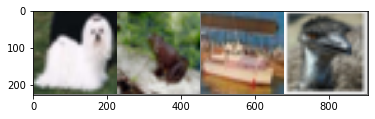

  dog  frog  ship  bird


In [44]:
def show_image(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

#学習データからデータを取得
data_iterator = iter(train_data_loader)
images, labels = data_iterator.next()

#画像を表示
show_image(torchvision.utils.make_grid(images[:4]))

#ラベルを表示
print(' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [0]:
# 「3*3 convolution層」
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)
    
# 入力サイズ：（H、W）、フィルターサイズ：（FH、FW）、出力サイズ：（OH、OW）、パディング：P、ストライド：S
# OH = (H + 2P - FH) / S + 1
# OW = (W + 2P - FW) / S + 1

# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x) #　「3*3 convolution層」
        out = self.bn1(out) #　「BatchNorm層」　　　　：アクティベーションの分布を調整し、過学習を抑える
        out = self.relu(out)  #　「ReLU層」
        out = self.conv2(out) #　「3*3 convolution層」
        out = self.bn2(out) #　「BatchNorm層」
        if self.downsample: #　スキップ構造、ショートカット、バイパス
          residual = self.downsample(x)   #　「ResNet」の「layer１」、「layer2」の場合、入る。　　downsample：「3*3 convolution層」　から「BatchNorm層」
        out += residual
        out = self.relu(out)    #　「ReLU層」
        return out

# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64        # MNISTだと１６だったが、駄目で、６４にすると動いた（CIFER-10は「３２×３２」だから？）
        self.conv = conv3x3(3, 64)    # RGBなので入力チャネル数は3
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[0], 2)
        self.layer3 = self.make_layer(block, 256, layers[1], 2)
        self.avg_pool = nn.AvgPool2d(8)   #「Avarageプーリング層」 
        self.fc = nn.Linear(1024, num_classes) #64/2 * 64/2 

    def make_layer(self, block, out_channels, blocks, stride=1):     
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):     #「layer２」、「layer３」の場合入る
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride), #「3*3 convolution層」
                nn.BatchNorm2d(out_channels)) #「BatchNorm層」
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):   # [1, 2]
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x) #「3*3 convolution層」            224*224
        out = self.bn(out)  #「BatchNorm層」
        out = self.layer1(out)    #「make_layer」から「Residual block」
        out = self.layer2(out)    #「make_layer」から「Residual block」
        out = self.layer3(out)    #「make_layer」から「Residual block」
        out = self.avg_pool(out)   #「Avarageプーリング層」 112*112
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [0]:
# Create ResNet
net_args = {
    "block": ResidualBlock,
    "layers": [2, 2, 2, 2] 
#    "layers": [3, 4, 6, 3]  #resnet18
}
model = ResNet(**net_args)

# Cross Entropy Loss 
error = nn.CrossEntropyLoss()
#withEdit付きでやるといい。

# Adam Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

In [64]:
model.to(device)

ResNet(
  (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=

In [75]:
#学習回数
MAX_EPOCH = 10     #20

for epoch in range(MAX_EPOCH):

  total_loss = 0.0

  for i, data in enumerate(train_data_loader, 0): #　12500回ループ

    train_data, teacher_labels = data
#    train_data = train_data.cuda()
#    teacher_labels = teacher_labels.cuda()
    train_data, teacher_labels = train_data.cuda(), teacher_labels.cuda()
    #計算された勾配を削除
    optimizer.zero_grad()
    #予測計算
    outputs = model(train_data)
    #微分計算
    loss = error(outputs, teacher_labels)
    loss.backward()
    #勾配を更新
    optimizer.step()
    #誤差を累計
    total_loss += loss.item()

    #2000ミニバッチずつ進捗表示
    if i % 100 == 99:
      print('学習進捗：[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, total_loss / 100))
      total_loss = 0.0
  
  print('学習終了')

学習進捗：[1,   100] loss: 0.601
学習進捗：[1,   200] loss: 0.573
学習進捗：[1,   300] loss: 0.588
学習進捗：[1,   400] loss: 0.608
学習進捗：[1,   500] loss: 0.631
学習進捗：[1,   600] loss: 0.615
学習進捗：[1,   700] loss: 0.609
学習進捗：[1,   800] loss: 0.598
学習進捗：[1,   900] loss: 0.632
学習進捗：[1,  1000] loss: 0.640
学習進捗：[1,  1100] loss: 0.627
学習進捗：[1,  1200] loss: 0.677
学習進捗：[1,  1300] loss: 0.650
学習進捗：[1,  1400] loss: 0.645
学習進捗：[1,  1500] loss: 0.692
学習終了
学習進捗：[2,   100] loss: 0.524
学習進捗：[2,   200] loss: 0.541
学習進捗：[2,   300] loss: 0.577
学習進捗：[2,   400] loss: 0.599
学習進捗：[2,   500] loss: 0.541
学習進捗：[2,   600] loss: 0.559
学習進捗：[2,   700] loss: 0.573
学習進捗：[2,   800] loss: 0.579
学習進捗：[2,   900] loss: 0.600
学習進捗：[2,  1000] loss: 0.602
学習進捗：[2,  1100] loss: 0.626
学習進捗：[2,  1200] loss: 0.633
学習進捗：[2,  1300] loss: 0.603
学習進捗：[2,  1400] loss: 0.592
学習進捗：[2,  1500] loss: 0.616
学習終了
学習進捗：[3,   100] loss: 0.502
学習進捗：[3,   200] loss: 0.463
学習進捗：[3,   300] loss: 0.549
学習進捗：[3,   400] loss: 0.535
学習進捗：[3,   500] loss: 0.546
学習進捗：[3,  

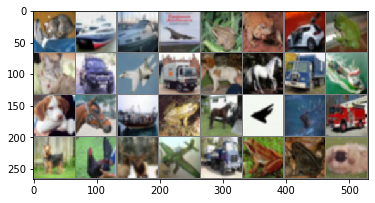

正解教師ラベル：　   cat  ship  ship plane


In [66]:
data_iterator = iter(test_data_loader)
images, labels = data_iterator.next()

#画像表示
show_image(torchvision.utils.make_grid(images))
print('正解教師ラベル：　', ' '.join('%5s' % class_names[labels[j]] for j in range(4)))

In [67]:
#テスト
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('予測：　', ' '.join('%5s' % class_names[predicted[j]] for j in range(4)))

RuntimeError: ignored

In [76]:
#検証
count_when_correct = 0
total = 0
with torch.no_grad():
  for data in test_data_loader: #2500回ループ
    test_data, teacher_labels = data
    test_data, teacher_labels = test_data.cuda(), teacher_labels.cuda()
    results = model(test_data)
    _, predicted = torch.max(results.data, 1)
    total += teacher_labels.size(0)
    count_when_correct += (predicted == teacher_labels).sum().item()

print('10000 検証画像に対しての正解率： %d %%' % (100 * count_when_correct / total))

10000 検証画像に対しての正解率： 68 %
